## Step 0: Importing modules

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

c:\Users\basic\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\basic\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Step 1: Statistical Arbitrage -- Pairs Trading

Pairs trading is a form of statistical arbitrage that assumes that the prices of highly cointegrated assets/stocks (such as those in the same industry with similar size and business models) will most often move in the same direction together, and that large temporary divergences in their prices/returns will revert back. 

To begin pairs trading, we first need to identify two highly cointegrated stocks. Cointegration is a measure of how much two time series move together and remain close to each other over time.

Some code modified from FINM 25000.

In [3]:
from statsmodels.tsa.stattools import coint


In [24]:
coca_cola_price = yf.download("KO", start="2014-01-01", end="2024-01-01")['Adj Close']
pepsico_price = yf.download("PEP", start="2014-01-01", end="2024-01-01")['Adj Close']

pairs_trading_data = pd.DataFrame({"KO": coca_cola_price["KO"], "PEP": pepsico_price["PEP"]}).dropna()


score, pvalue, _ = coint(pairs_trading_data["KO"], pairs_trading_data["PEP"])
print(f'P-value: {pvalue}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

P-value: 0.0028529707341931453


<Axes: xlabel='Date'>

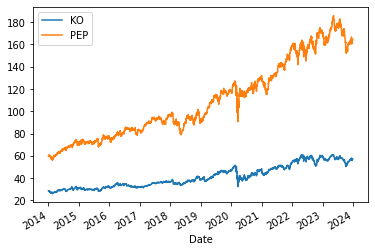

In [26]:
pairs_trading_data.plot()

Here we see that the prices of Coca Cola (KO) and PepsiCo (PEP) are statistically cointegrated with a p-value of < 0.05 (it helps that we chose a large timeframe considering we are using daily prices).

Now we can calulate the spread of their prices and calculate a rolling z-score of the spread (we will use a 30 day timeframe) for use in deriving our trading signals.

In [32]:
pairs_trading_data["spread"] = pairs_trading_data["PEP"] - pairs_trading_data["KO"]
pairs_trading_data["rolling_zscore"] = (pairs_trading_data["spread"] - pairs_trading_data["spread"].rolling(30).mean()) / pairs_trading_data["spread"].rolling(30).std()

<Axes: xlabel='Date'>

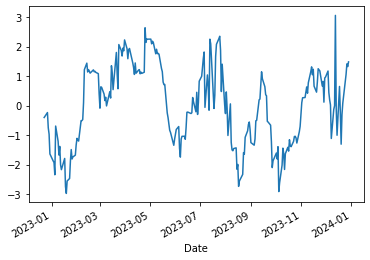

In [33]:
pairs_trading_data["rolling_zscore"].tail(255).plot() # Plot last year rolling z-score

Now we can define our trading signals. When the spread's Z-score is below -1, that means that the spread is unusually small, and we can expect it to increase to it's usual level (hence go long the pricier stock PEP). When the spread's Z-score is above 1, it is unusually large, so we can expect it to decrease to it's usual level (hence go short the pricier stock PEP).

In [34]:
pairs_trading_data["long_signal"] = np.where(pairs_trading_data["rolling_zscore"] < -1, 1, 0)
pairs_trading_data["short_signal"] = np.where(pairs_trading_data["rolling_zscore"] > 1, -1, 0)
pairs_trading_data["signal"] = pairs_trading_data["long_signal"] + pairs_trading_data["short_signal"]

In [35]:
pairs_trading_data

,KO,PEP,spread,rolling_zscore,long_signal,short_signal,signal
Date,,,,,,,
2014-01-02,28.724308,59.668812,30.944504,NaN,0,0,0
2014-01-03,28.583008,59.770580,31.187572,NaN,0,0,0
2014-01-06,28.448790,59.799629,31.350840,NaN,0,0,0
2014-01-07,28.533564,60.671772,32.138208,NaN,0,0,0
2014-01-08,28.215668,60.497345,32.281677,NaN,0,0,0
...,...,...,...,...,...,...,...
2023-12-22,56.591599,162.476974,105.885376,0.082703,0,0,0
2023-12-26,56.824493,163.620377,106.795883,1.057528,0,-1,-1
2023-12-27,56.970043,164.143616,107.173573,1.414148,0,-1,-1


Now we can simulate a backtest (since we are using rolling only):

In [38]:
pairs_trading_data['Return'] = pairs_trading_data["PEP"].pct_change() * pairs_trading_data['signal'].shift() # Remember we are going long/short KP. We could also go short/long PEP correspondingly
pairs_trading_data['Total Return'] = (1 + pairs_trading_data['Return']).cumprod()


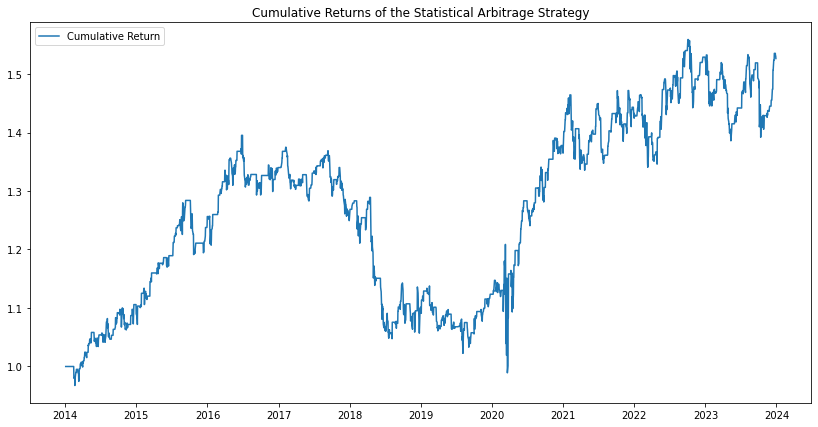

In [41]:
plt.figure(figsize=(14, 7))
plt.plot(pairs_trading_data.index, pairs_trading_data['Total Return'], label='Cumulative Return')
plt.title('Cumulative Returns of the Statistical Arbitrage Strategy')
plt.legend()
plt.show()

TODO (Optional): Calculate the mean annual returns and sharpe ratio of the strategy. HINT: Remember to consider the timeframe we are operating on and the number of trading days in a year!

TODO 2 (Optional): Now that you have a basic metric to analyze the strategy's performance, play around with the strategy (finding different pairs, changing rolling z-score window size, zscore threshold, etc.) to try and find a better sharpe configuration of this strategy based on a sound backtest.

## Step 2: Trend/Momentum Trading